In [1]:
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# Define the paths

In [2]:
base_dir = "C:/Users/danis/Coding/crop-disease-recognition-cnn"
preprocessing_dir = os.path.join(base_dir, "Preprocessing")
models_dir = os.path.join(base_dir, "Models")

# Create models directory if it doesn't exist

In [3]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Data transformations

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(preprocessing_dir, x), data_transforms[x])
                    for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Use GPU if available

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50 model

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function

In [9]:
def train_model(model, criterion, optimizer, num_epochs=10, accumulate_steps=4):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            optimizer.zero_grad()
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if (i + 1) % accumulate_steps == 0:
                            optimizer.step()
                            optimizer.zero_grad()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                optimizer.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record loss and accuracy
            if phase == 'train':
                train_loss_over_time.append(epoch_loss)
                train_acc_over_time.append(epoch_acc.item())
            else:
                val_loss_over_time.append(epoch_loss)
                val_acc_over_time.append(epoch_acc.item())
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss_over_time, val_loss_over_time, train_acc_over_time, val_acc_over_time, best_acc, time_elapsed

# Train the model

In [10]:
model, train_loss, val_loss, train_acc, val_acc, best_acc, training_time = train_model(model, criterion, optimizer, num_epochs=10, accumulate_steps=4)

Epoch 1/10
----------
train Loss: 0.5309 Acc: 0.8286
val Loss: 0.1741 Acc: 0.9409

Epoch 2/10
----------
train Loss: 0.2374 Acc: 0.9229
val Loss: 0.3045 Acc: 0.9188

Epoch 3/10
----------
train Loss: 0.2008 Acc: 0.9341
val Loss: 0.1356 Acc: 0.9513

Epoch 4/10
----------
train Loss: 0.1747 Acc: 0.9427
val Loss: 0.2083 Acc: 0.9508

Epoch 5/10
----------
train Loss: 0.1437 Acc: 0.9517
val Loss: 0.0476 Acc: 0.9833

Epoch 6/10
----------
train Loss: 0.1286 Acc: 0.9586
val Loss: 0.4526 Acc: 0.9788

Epoch 7/10
----------
train Loss: 0.1304 Acc: 0.9571
val Loss: 0.0514 Acc: 0.9808

Epoch 8/10
----------
train Loss: 0.1223 Acc: 0.9589
val Loss: 0.0447 Acc: 0.9862

Epoch 9/10
----------
train Loss: 0.1130 Acc: 0.9620
val Loss: 0.0508 Acc: 0.9838

Epoch 10/10
----------
train Loss: 0.1127 Acc: 0.9624
val Loss: 0.0262 Acc: 0.9902

Training complete in 21m 47s
Best val Acc: 0.9902


# Save the model

In [11]:
torch.save(model.state_dict(), os.path.join(models_dir, 'resnet50_best_model.pth'))

# Visualizations

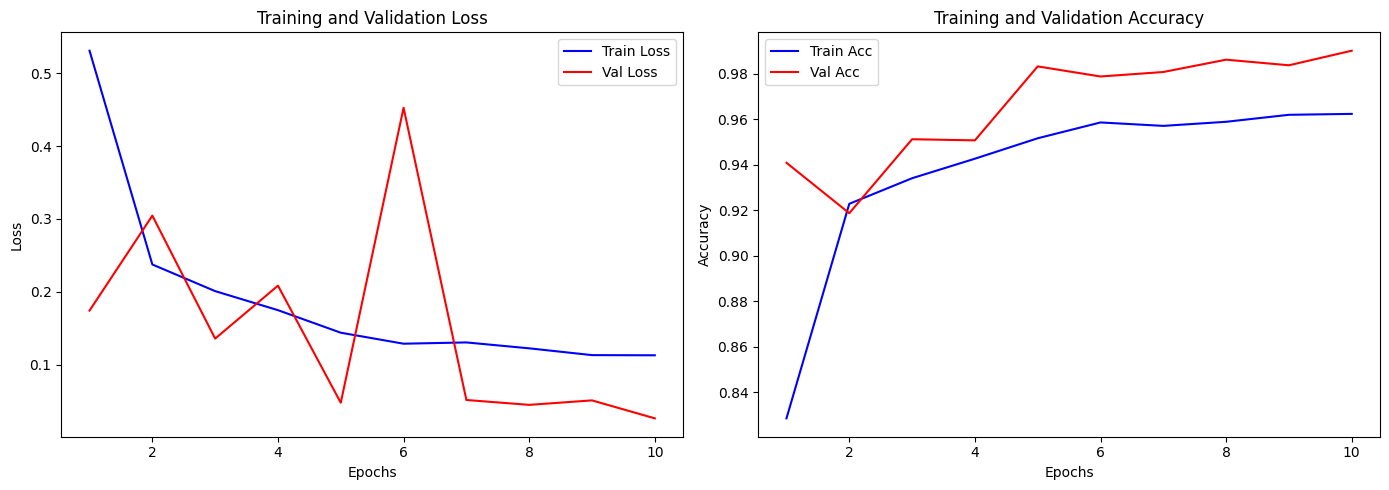

In [12]:
epochs = range(1, 11)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Train Acc')
plt.plot(epochs, val_acc, 'r', label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Record the best accuracy and most loss

In [13]:
most_loss = max(val_loss)
best_accuracy = best_acc.item()

# Print summary

In [14]:
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Most Loss: {most_loss:.4f}')
print(f'Total Training Time: {training_time // 60:.0f}m {training_time % 60:.0f}s')

Best Accuracy: 0.9902
Most Loss: 0.4526
Total Training Time: 21m 47s
